In [11]:
# CVAE-GAN 
# finished at 2020-11-18

In [18]:
!/opt/bin/nvidia-smi

!rm -rf /content/sample_data

!rm -rf /content/img_CVAE-GAN

Wed Nov 25 12:26:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    34W /  70W |   1267MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
import os, time
import imageio
import matplotlib.pyplot as plt


In [6]:
class VAE(nn.Module):
    def __init__(self):

        super(VAE, self).__init__()
        
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
            
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm2d(32),
        )

        self.encoder_fc1=nn.Linear(32*7*7,nz)
        self.encoder_fc2=nn.Linear(32*7*7,nz)
        self.Sigmoid = nn.Sigmoid()
        self.decoder_fc = nn.Linear(nz+10,32 * 7 * 7)
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
            nn.Tanh(),
        )

    def noise_reparameterize(self,mean,logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def encoder(self,x):
        out1, out2 = self.encoder_conv(x), self.encoder_conv(x)
        mean = self.encoder_fc1(out1.view(out1.shape[0], -1))
        logstd = self.encoder_fc2(out2.view(out2.shape[0], -1))
        z = self.noise_reparameterize(mean, logstd)
        return z,mean,logstd

    def decoder(self,z):
        out3 = self.decoder_fc(z)
        out3 = out3.view(out3.shape[0], 32, 7, 7)
        out3 = self.decoder_deconv(out3)
        return out3

    def forward(self, x):
        z = self.encoder(x)
        output = self.decoder(z)
        return output

In [5]:
class Discriminator(nn.Module):
    def __init__(self,outputn=1):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2)),
        )
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, outputn),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.dis(input)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.squeeze(1)

In [7]:
def loss_function(recon_x,x,mean,logstd):
    # BCE = F.binary_cross_entropy(recon_x,x,reduction='sum')
    MSE = MSECriterion(recon_x,x)
    # 因为var是标准差的自然对数，先求自然对数然后平方转换成方差
    var = torch.pow(torch.exp(logstd),2)
    KLD = -0.5 * torch.sum(1+torch.log(var)-torch.pow(mean,2)-var)
    return MSE+KLD

In [19]:
if __name__ == '__main__':
    batchSize = 128
    imageSize = 28
    nz = 100
    nepoch = 200
     
    if not os.path.exists('./img_CVAE-GAN'):
        os.mkdir('./img_CVAE-GAN')

    random.seed(1)
    torch.manual_seed(1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
    cudnn.benchmark = True

    dataset = datasets.MNIST(root='./data',
                         train=True,
                         transform=transforms.Compose([transforms.ToTensor()]),
                         download=True
                         )

    dataloader = torch.utils.data.DataLoader(dataset,
                        batch_size=batchSize,
                        shuffle=True)
    
    print("=====> Initialization")
    # encoder + decoder = VAE
    vae = VAE().to(device)
    # vae.load_state_dict(torch.load('./CVAE-GAN-VAE.pth'))

    # discriminator
    D = Discriminator(1).to(device)
    # D.load_state_dict(torch.load('./CVAE-GAN-Discriminator.pth'))

    # Classifier
    C = Discriminator(10).to(device)
    # C.load_state_dict(torch.load('./CVAE-GAN-Classifier.pth'))
    
    criterion = nn.BCELoss().to(device)
    MSECriterion = nn.MSELoss().to(device)

    loss_d = []
    loss_c = []
    loss_g = []

    optimizerD = optim.Adam(D.parameters(), lr=0.0002,betas=(0.5, 0.999))
    optimizerC = optim.Adam(C.parameters(), lr=0.0002,betas=(0.5, 0.999))
    optimizerVAE = optim.Adam(vae.parameters(), lr=0.0002,betas=(0.5, 0.999))
    
    # sample_label
    s_label = []
    for i in [0,0,1,8,0,9,4,0,1,0,5,3]:
      s_label += [ i for _ in range(8)]
    specific_label = torch.zeros((96, 10)).cuda()
    specific_label[torch.arange(96), s_label] = 1

    print("=====> Start Training")
    start_time = time.time()
    for epoch in range(nepoch):

        epoch_start_time = time.time()

        for i, (data,label) in enumerate(dataloader, 0):
            
            # data processing
            data = data.to(device)
            label_onehot = torch.zeros((data.shape[0], 10)).to(device)
            label_onehot[torch.arange(data.shape[0]), label] = 1
            batch_size = data.shape[0]

            # training C with real
            output = C(data)
            real_label = label_onehot.to(device)
            errC = criterion(output, real_label)
            C.zero_grad()
            errC.backward()
            optimizerC.step()

            # training D with real and fake
            output = D(data)
            real_label = torch.ones(batch_size).to(device)   
            fake_label = torch.zeros(batch_size).to(device)  
            errD_real = criterion(output, real_label)

            z = torch.randn(batch_size, nz + 10).to(device)
            fake_data = vae.decoder(z)
            output = D(fake_data)
            errD_fake = criterion(output, fake_label)

            errD = errD_real+errD_fake
            D.zero_grad()
            errD.backward()
            optimizerD.step()

            # update VAE(G)1
            z,mean,logstd = vae.encoder(data)
            z = torch.cat([z,label_onehot],1)
            recon_data = vae.decoder(z)
            vae_loss1 = loss_function(recon_data,data,mean,logstd)

            # update VAE(G)2
            output = D(recon_data)
            real_label = torch.ones(batch_size).to(device)
            vae_loss2 = criterion(output,real_label)

            # update VAE(G)3
            output = C(recon_data)
            real_label = label_onehot
            vae_loss3 = criterion(output, real_label)

            vae.zero_grad()
            vae_loss = vae_loss1+vae_loss2+vae_loss3
            vae_loss.backward()
            optimizerVAE.step()

        # print per-epoch
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
        print('[%d/%d] time: %.2f Loss_D: %.4f Loss_C: %.4f Loss_G: %.4f'
                  % (epoch+1, nepoch, per_epoch_ptime, errD.item(),errC.item(),vae_loss.item()))
        
        loss_d.append(errD.item())
        loss_c.append(errC.item())
        loss_g.append(vae_loss.item())

        sample = torch.randn(data.shape[0], nz).to(device)
        # data.shape[0] == 96
        # sample.shape: 96*100
        # real_label.shape: 96*10
        # sample.shape after cat: 96*110
        sample = torch.cat([sample,specific_label],1)
        # output.shape: torch.Size([96, 1, 28, 28])
        output = vae.decoder(sample)
        fake_images = make_grid(output.cpu(), nrow=8, normalize=True).detach()
        save_image(fake_images, './img_CVAE-GAN/fake_images-{}.png'.format(epoch+1))

    end_time = time.time()
    total_time = end_time - start_time
    print("total time: %.2f " % total_time )

images = []
for e in range(nepoch):
    img_name = './img_CVAE-GAN/fake_images-' + str(e+1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('./generation_animation.gif', images, fps=2)


# torch.save(vae.state_dict(), './CVAE-GAN-VAE.pth')
# torch.save(D.state_dict(),'./CVAE-GAN-Discriminator.pth')
# torch.save(C.state_dict(),'./CVAE-GAN-Classifier.pth')

=====> Initialization
=====> Start Training
[1/200] time: 15.47 Loss_D: 0.0786 Loss_C: 0.0297 Loss_G: 45.7630
[2/200] time: 15.59 Loss_D: 0.1033 Loss_C: 0.0142 Loss_G: 26.4593
[3/200] time: 15.69 Loss_D: 0.1087 Loss_C: 0.0109 Loss_G: 20.5055
[4/200] time: 15.68 Loss_D: 0.1221 Loss_C: 0.0104 Loss_G: 24.4189
[5/200] time: 15.78 Loss_D: 0.1699 Loss_C: 0.0183 Loss_G: 19.8831
[6/200] time: 15.87 Loss_D: 0.0980 Loss_C: 0.0114 Loss_G: 16.4556
[7/200] time: 15.76 Loss_D: 0.1546 Loss_C: 0.0038 Loss_G: 19.4030
[8/200] time: 15.69 Loss_D: 0.0737 Loss_C: 0.0163 Loss_G: 20.1188
[9/200] time: 15.69 Loss_D: 0.0600 Loss_C: 0.0075 Loss_G: 22.8901
[10/200] time: 15.73 Loss_D: 0.0734 Loss_C: 0.0004 Loss_G: 10.7457
[11/200] time: 15.71 Loss_D: 0.0674 Loss_C: 0.0025 Loss_G: 11.5275
[12/200] time: 15.69 Loss_D: 0.0519 Loss_C: 0.0006 Loss_G: 27.9790
[13/200] time: 15.53 Loss_D: 0.2324 Loss_C: 0.0031 Loss_G: 12.0133
[14/200] time: 15.38 Loss_D: 0.0382 Loss_C: 0.0005 Loss_G: 13.4912
[15/200] time: 15.43 Loss_D

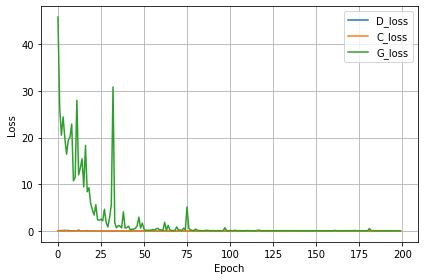

In [20]:
def show_train_hist(d_loss, c_loss, g_loss):
    x = range(len(d_loss))

    y1 = d_loss
    y2 = c_loss
    y3 = g_loss

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='C_loss')
    plt.plot(x, y3, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=1)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

show_train_hist(loss_d, loss_c, loss_g)

In [21]:
!cp -r /content/img_CVAE-GAN/ /content/drive/MyDrive